In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, AvgPool2D  
from keras import Model, Input
from keras.applications.vgg19 import VGG19 
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB4, ResNet50,ResNet101

from tensorflow.keras.optimizers import Adam
from keras.models import load_model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load EEG Dataset

In [2]:
BASE_PATH = '../input/digs-data'
data = loadmat(os.path.join(BASE_PATH, 'X.mat'))['cdata']
fs = 256;   # sampling frequency

X, y = [], []
for x in data:
    X.append(x[0])
    y.append(x[1][0][0][0])

X = np.array(X)
y = np.array(y)

print('Input:', X.shape)
print('Output:', y.shape)

Input: (663, 16, 1280)
Output: (663,)


# Data Spliting  using 80-20 ratio of   Training and testing 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

y_train =np.array(y_train)  
y_test =np.array(y_test)
y_test_1 = np.array(y_test)

#### One hot encoder of labale 

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.transform(y_test.reshape(-1,1)).toarray()

### Reshape of train and test data 
X_train =  X_train.reshape(-1, X_train.shape[1], X_train.shape[2],1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2],1)
print('X_train: {0}\nX_test : {1}'.format(X_train.shape, X_test.shape))
print('X_train: {0}\nX_test : {1}\ny_train: {2}\ny_test : {3}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

  # Display input shape used for model buliding
input_shape = X_train[0,:].shape
print('Input shape: ',input_shape)

X_train: (530, 16, 1280, 1)
X_test : (133, 16, 1280, 1)
X_train: (530, 16, 1280, 1)
X_test : (133, 16, 1280, 1)
y_train: (530, 2)
y_test : (133, 2)
Input shape:  (16, 1280, 1)


# Model Buliding 

In [4]:
input_shape = X_train[0,:].shape
model = Sequential([Conv2D(filters = 20, kernel_size = (3,3), activation ='relu', input_shape = input_shape),
                    MaxPool2D(pool_size=(2,21)), 
                    Conv2D(filters = 10,kernel_size = (3,3), activation ='relu', input_shape = input_shape),
                    
#                     GlobalAveragePooling2D(),
#                     AvgPool2D(),
                    Flatten(), 
#                     Dropout(0.5),
                    Dense(50, activation = "relu"), Dense(80, activation = "relu"), Dense(2, activation = "softmax")])
model.summary()
start = time.time()
opt = Adam(learning_rate=0.001)
model.compile(loss= 'binary_crossentropy', optimizer = opt ,metrics = ['accuracy'])
                                                                       
history = model.fit(X_train, y_train, batch_size=80, epochs=50, shuffle=True,verbose=1,validation_split=0.2)

score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {0:3.4f}".format(score[1]))

score =model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: {0:3.4f}".format(score[1]))
# print("Testing loss: {0:3.4f}".format(score[0]))

preds_test = model.predict(X_test) # label scores 
preds_train = model.predict(X_train)

model.save("ADNet.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 1278, 20)      200       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 60, 20)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 58, 10)         1810      
                                                                 
 flatten (Flatten)           (None, 2900)              0         
                                                                 
 dense (Dense)               (None, 50)                145050    
                                                                 
 dense_1 (Dense)             (None, 80)                4080      
                                                        

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model evaluation

In [5]:
y_pred = np.argmax(preds_test, axis=1) # predicted classes 
y_test = np.argmax(y_test, axis=1) # true classes
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score= metrics.f1_score(y_test, y_pred)
sensitivity = metrics.recall_score(y_test, y_pred, pos_label=1)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
#precision = metrics.precision_score(y_test, y_pred)
from sklearn.metrics import roc_curve
#y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test,y_pred)
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(accuracy,f1_score,sensitivity,specificity,auc)

[[76  2]
 [ 0 55]]
0.9849624060150376 0.9821428571428572 1.0 0.9743589743589743 0.9871794871794871


# Calculate Floating Point operations per sec (GFLOPS)

In [6]:
pip install keras-flops

Note: you may need to restart the kernel to use updated packages.


In [7]:
from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# flops

KeyError: "Registering two statistical functions with name 'AddV2,flops'! (Previous registration was in register /opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/registry.py:65)"

# Calcualte inteferance Time

In [8]:
import time
import numpy as np

input_data = X_test  # Replace with your input shape
# model = VGG16()

start_time = time.time()
_ = model.predict(input_data)
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time)

5/5 [==============================] - 0s 55ms/step
Inference Time: 0.39218997955322266


# Accuracy and Loss Curve

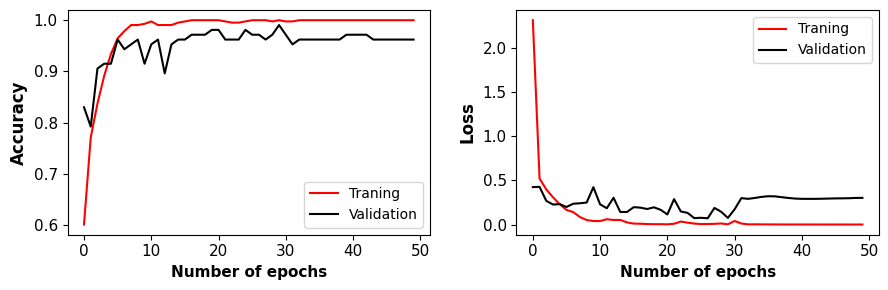

In [9]:
# fig = plt.figure(figsize=(2, 1))
fig, axs = plt.subplots(1,2,figsize=(9,3))
labels = ['Traning','Validation']
axs[0,].plot(history.history['accuracy'],'-r', lw=1.5)
axs[0].plot(history.history['val_accuracy'], '-k')
axs[0].set_xlabel('Number of epochs', weight='bold',fontsize=11)
axs[0].set_ylabel('Accuracy', weight='bold',fontsize=12)
axs[0].tick_params(labelsize=11)
axs[0].legend( labels, loc='lower right',ncol=1)

axs[1].plot(history.history['loss'],'-r', lw=1.5)
axs[1].plot(history.history['val_loss'], '-k')
axs[1].set_xlabel('Number of epochs', weight='bold',fontsize=11)
axs[ 1].set_ylabel('Loss', weight='bold',fontsize=12)
axs[1].tick_params(labelsize=11)
axs[1].legend( labels, loc='upper right',ncol=1)


fig.tight_layout(w_pad=2, h_pad=2 )
plt.savefig('LCADNet_loss.pdf')
# plt.savefig('C:\\Users\\213\\Desktop\\ACC_Loss_curve\\ResNet50.pdf',dpi=1200, transparent = True)

plt.show()

# Intermediate representations for all layers

1/1 [==============================] - 0s 91ms/step
(1, 14, 1278, 20)
(1, 7, 60, 20)
(1, 5, 58, 10)
(1, 2900)
(1, 50)
(1, 80)
(1, 2)


/tmp/ipykernel_771/4146748647.py:34: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/tmp/ipykernel_771/4146748647.py:37: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


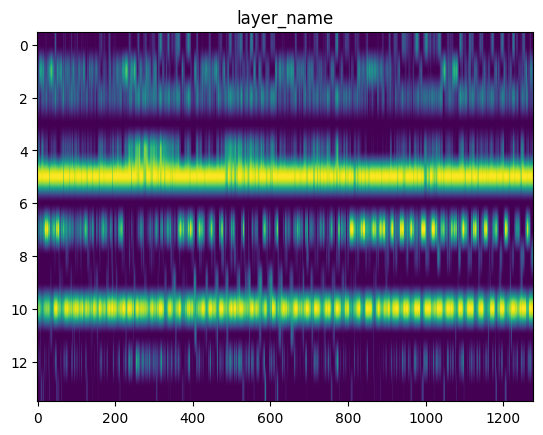

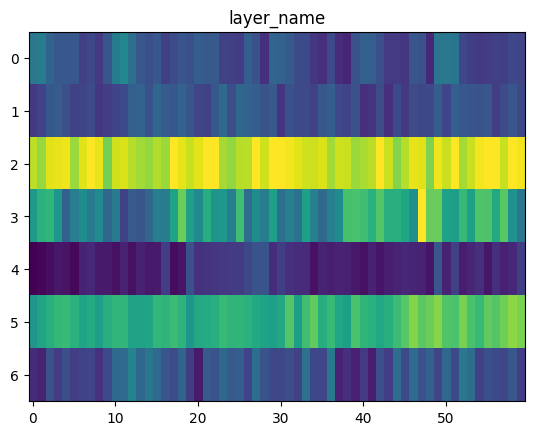

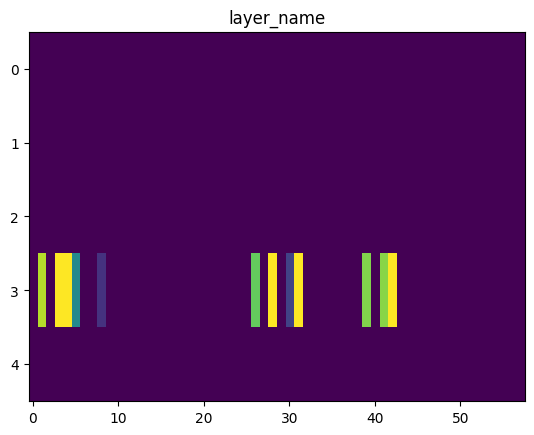

In [10]:
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
x_test = X_test[0].reshape(1,16,1280,1) #load_img(img_path, target_size=(150, 150))

# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x_test)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_filt = feature_map.shape[-1]  # number of features in the feature map
    n_features = feature_map.shape[2]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
#     display_grid = np.ones((size, n_filt * n_features))
    display_grid = np.ones((size* n_filt, n_features))
#     print(display_grid)
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_filt):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
#         display_grid[:, i * n_features : (i + 1) * n_features] = x # Tile each filter into a horizontal grid
#         display_grid[i * size : (i + 1) * size, :] = x # Tile each filter into a horizontal grid
    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure()
    plt.title ('layer_name')
    plt.grid  ( False )
    plt.imshow( x, aspect='auto', cmap='viridis' ) 
    plt.savefig('1-0.jpg')

# Scatter plot of T SNE using flattern layers values of model 

In [1]:
successive_outputs = [layer.output for layer in model.layers]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs[6])
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(X_test)
np.array(successive_feature_maps).shape

from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
label= label_encoder.fit_transform(y_test_1)
label =  pd.DataFrame(label, columns=['label'] )
df = pd.DataFrame(successive_feature_maps)
df['label'] = label
# df2 = pd.concat(data, axis=1)
# df.to_csv('vgg16_flat.csv')

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1,early_exaggeration=2, random_state=1)
z = tsne.fit_transform(df) 
df = pd.DataFrame()

df["Label"] = label
df["Label"] = df["Label"].apply(lambda x: 'NC' if x==0 else 'AD')
df["Component-1"] = z[:,0]
df["Component-2"] = z[:,1]
plt.figure(figsize=(4,3))

# sns.scatterplot(data=df, x="Component-1", y="Component-2", hue="Label", edgecolor='none', palette=dict(AD="r", NC="g"),legend=None, markers="s") 
# plt.legend(ncol=2 , fontsize='12')
# sns.scatterplot(data=df[df["Label"] == 'AD'], x="Component-1", y="Component-2", edgecolor="g", facecolor="none", alpha =1.0, lw=2, marker='o', label='AD', legend=None)

plt.scatter(df[df["Label"] == 'AD']['Component-1'], df[df["Label"] == 'AD']['Component-2'], edgecolors='r', marker='o', s=60, alpha=1, facecolors='none',linewidths= 1.5)
# Scatter plot for 'NC' class
# sns.scatterplot(data=df[df["Label"] == 'NC'], x="Component-1", y="Component-2", facecolor='r', marker='+', hue_norm=1, label='NC', legend=None)
plt.scatter(df[df["Label"] == 'NC']['Component-1'], df[df["Label"] == 'NC']['Component-2'], facecolors='g', marker='+', s=60, alpha=1,linewidths= 1.5)

plt.xlabel('',weight='bold',fontsize=12)
plt.ylabel('',weight='bold',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.savefig('ResNet50_Tsne_plot.pdf',dpi=300, bbox_inches = "tight" )

NameError: name 'model' is not defined